# CODICE COME MAIN_METROPOLIS_LU CHE CERCA DI USARE IL NETWORK DEL PROF 14/05/2025
Codice che funziona, bisogna provare a farlo runnare per vedere quanto ci mette a trovare le accuracies

## 1 Initialize the Network

In [66]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations
import seaborn as sns

In [67]:
# Carica la matrice fc (ad esempio dal file fc.txt)
fc = np.loadtxt('fc.txt')

# Crea la matrice A0 inizialmente vuota (di dimensioni 100x100)
n = fc.shape[0]
A_true = np.zeros((n, n))

# Per ogni coppia di nodi (i, j), crea una connessione se un numero casuale <= fc[i, j]
for i in range(n):
    for j in range(n):
        
        prob = fc[i, j]
        treshold= 0.3
        if prob >= treshold:
            A_true[i, j] = 1  # Connetti i nodi i e j
        

# Adjacent matrix 
print(A_true)

[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [68]:
# network creation
G_true = nx.from_numpy_array(A_true)

# Verifica numero di nodi e archi
print(f"Numero di nodi: {G_true.number_of_nodes()}")
print(f"Numero di archi: {G_true.number_of_edges()}")

Numero di nodi: 100
Numero di archi: 805


In [69]:
def modify_network(G, modification_fraction):
    """
    Randomly removes and adds a fraction of edges in the network G.
    
    :param G: The input graph (NetworkX object).
    :param modification_fraction: Fraction of edges to modify.
    :return: Modified graph, list of removed edges, list of added edges.
    """
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Randomly remove edges
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Randomly add edges
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges

In [70]:
# Create an observed network by randomly modifying the true graph
modification_fraction = 0.2  # For example, modify 20% of the connections
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)


# Verifica numero di nodi e archi
print(f"Numero di nodi: {G_obs.number_of_nodes()}")
print(f"Numero di archi: {G_obs.number_of_edges()}")

Numero di nodi: 100
Numero di archi: 797


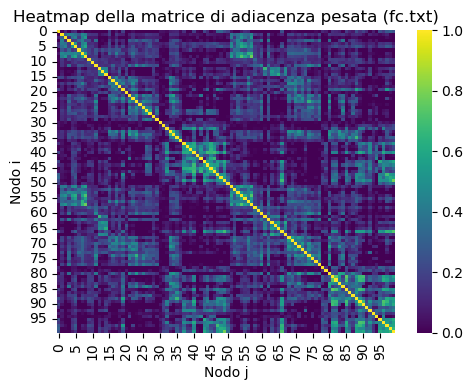

In [71]:
# === Heatmap della matrice di adiacenza ===
plt.figure(figsize=(5, 4))
sns.heatmap(fc, cmap='viridis')
plt.title('Heatmap della matrice di adiacenza pesata (fc.txt)')
plt.xlabel('Nodo j')
plt.ylabel('Nodo i')
plt.tight_layout()
plt.show()



In [72]:
##### PLOTS 
def plot_graph(G, title):
    """
    Plots the given graph with node colors based on their block assignment.

    :param G: NetworkX graph object.
    """
    pos = nx.spring_layout(G, k=0.8, seed=42)  # Adjust 'k' to control node spacing
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        edge_color='darkgrey', 
        node_color='skyblue', 
        node_size=300,  # Increase node size
        width=1.5,  # Increase edge width
        font_size=10, 
        font_color='black'
    )
    plt.title(title)
    plt.show()

def plot_modified_network(G, removed_edges, added_edges, title):
    """
    Plots the observed network with highlighted removals and additions.

    :param G: NetworkX graph object.
    :param removed_edges: List of edges removed from the original graph.
    :param added_edges: List of edges added to the original graph.
    :param title: Title of the plot.
    """
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Adjust 'k' to control node spacing
    
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        node_color='skyblue', 
        edge_color='gray', 
        node_size=300,  # Increase node size
        width=1.5,  # Increase edge width
        font_size=10, 
        font_color='black'
    )
    # Highlight removed edges in red (dashed)
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=1)
    # Highlight added edges in green (solid)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=1)
    
    plt.title(title)
    plt.show()
    


def plot_H_trace(H_burn_in, H_full_trace):
    """
    Plots the full trace of H(P), including the burn-in phase and sampling.

    :param H_burn_in: List of H(P) values during the burn-in phase.
    :param H_full_trace: List of H(P) values during the full MCMC sampling.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_burn_in)), H_burn_in, marker=',', linestyle='-', linewidth=0.5, label="Burn-in")
    plt.plot(range(len(H_burn_in), len(H_burn_in) + len(H_full_trace)), H_full_trace, marker=',', linestyle='-', linewidth=0.5, label="Sampling")
    plt.axvline(x=len(H_burn_in), color='r', linestyle='--', linewidth=1, label="End of burn-in")
    plt.xlabel("Iterations")
    plt.ylabel("H(P)")
    plt.title("Full Trace of H(P) Without Thinning")
    plt.legend()
    plt.show()


def plot_final_H_trace(H_final, thinning_interval):
    """
    Plots the final trace of H(P) after applying thinning.

    :param H_final: List of H(P) values after thinning.
    :param thinning_interval: Interval used for thinning.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_final)), H_final, marker='o', linestyle='-')
    plt.xlabel(f'Sampling iterations with thinning every {thinning_interval}')
    plt.ylabel('H(P)')
    plt.title('Final Trace of H(P) After Thinning')
    plt.show()


def plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious):
    """
    Plots the accuracy for Missing and Spurious Interactions.

    :param error_fractions: List of error fractions.
    :param accuracy_missing: Accuracy values for missing interactions.
    :param accuracy_spurious: Accuracy values for spurious interactions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for Missing Interactions
    ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
    ax1.set_xlabel('Fraction of removed links (f)')
    ax1.set_ylabel('Accuracy (probability)')
    ax1.set_title('Missing Interactions')
    ax1.legend()
    ax1.grid(True)

    # Plot for Spurious Interactions
    ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
    ax2.set_xlabel('Fraction of added links (f)')
    ax2.set_ylabel('Accuracy (probability)')
    ax2.set_title('Spurious Interactions')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


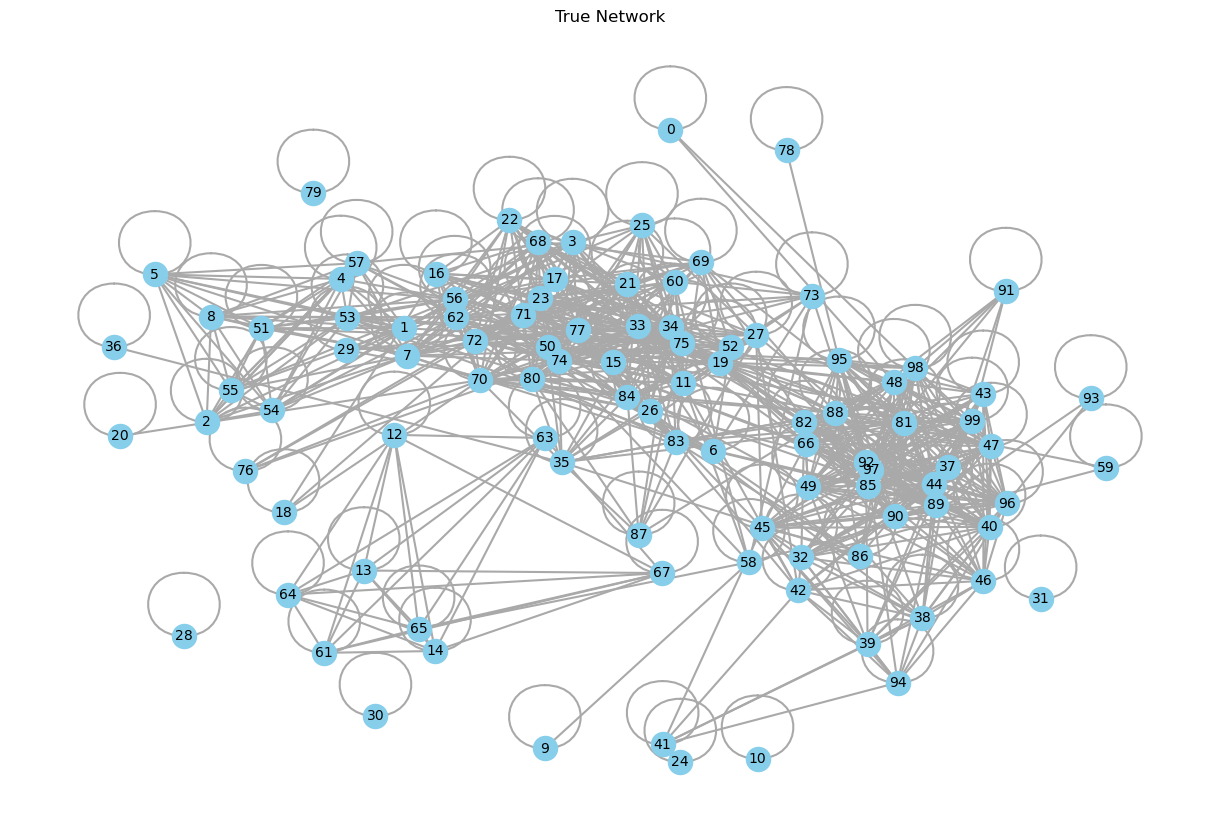

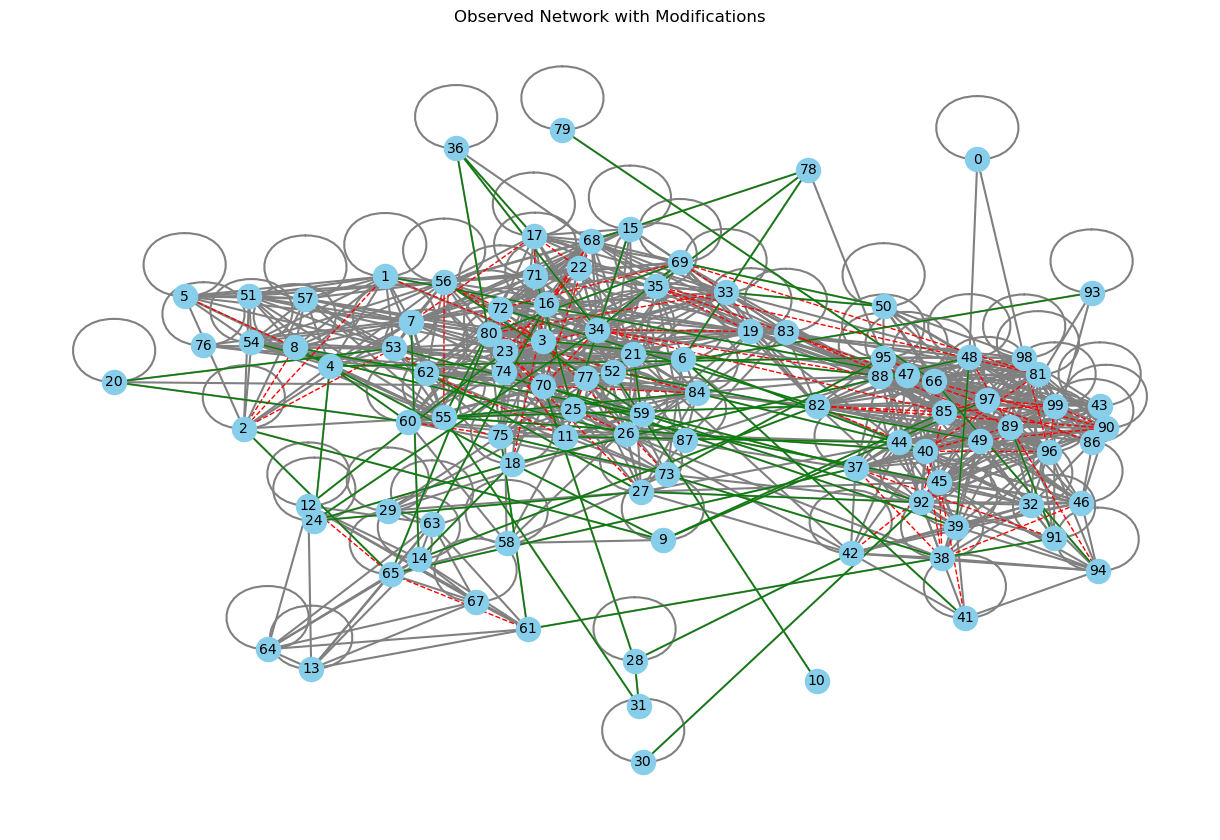

In [73]:
# Plot the true network
plot_graph(G_true, "True Network")

# Plot the observed network
plot_modified_network(G_obs, removed_edges, added_edges, "Observed Network with Modifications")

### 1.2 Computing Entropy in Network Partitions

In [74]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group


def calculate_H(P, G):
    """Calculates H(P) for a given partition P and graph G."""
    # Group nodes by block
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (maximum possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # Combinations of 2
    # Pairs of different groups
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Note: We add 1 to the denominator as per the formula and use log(comb) for the combinatorial term.
        H += math.log(r[key] + 1)
        # To avoid log(0) or errors, we use 0 if no observed links exist
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # For safety, if comb_value results in 0, we add a small epsilon
        H += math.log(comb_value)
    
    return H

# in caso aggiungo questo:
#if comb_value > 0:
    #H += math.log(comb_value)
#else:
    #H += 0


The formula for H(P) in your code:  
corresponds to the article's equation: [ H(P) = \sum_{\alpha \leq \beta} \left[ \ln(r_{\alpha\beta} + 1) + \ln\binom{r_{\alpha\beta}}{lO_{\alpha\beta}} \right] ]  
r[key] represents the maximum possible links between groups (denoted as ( r_{\alpha\beta} )).  
lO[key] represents the observed links between groups (denoted as ( lO_{\alpha\beta} )).  
The use of math.comb ensures the combinatorial term is calculated correctly.

### 1.3 MCMC Sampling for Network Partitions

This section introduces the Metropolis-Hastings MCMC algorithm to sample partitions of a given network. The function mcmc_trace_H performs the Markov Chain Monte Carlo (MCMC) sampling, first running a burn-in phase to reach equilibrium, then collecting partition samples without thinning. The acceptance criterion follows the Metropolis rule, ensuring that state transitions favor lower entropy configurations while allowing occasional increases for exploration. The output includes all recorded entropy values, enabling further analysis of the sampling process.

In [75]:
def metropolis_acceptance(delta_H):
    """Decides whether to accept a new state based on the Metropolis criterion."""
    return delta_H <= 0 or np.random.rand() < np.exp(-delta_H)


def mcmc_trace_H(G, equilibration, num_samples):
    """
    Performs MCMC sampling, collecting all H(P) values without thinning.

    :param G: NetworkX graph for sampling.
    :param equilibration: Number of burn-in iterations.
    :param num_samples: Total number of sampling iterations.
    :return: List of sampled partitions, H values during sampling, and full trace of H values.
    """
    num_nodes = len(G.nodes())
    P = initialize_partition(G)
    
    # Store H(P) values during burn-in
    H_burn_in = []
    for i in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        H_burn_in.append(calculate_H(P, G))  # Store all H(P) values in burn-in
    
    # Sampling phase without thinning
    partitions = []
    H_full_trace = []  # Stores all H(P) values during sampling without thinning
    for i in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        partitions.append(P.copy())
        H_full_trace.append(calculate_H(P, G))  # Records all H(P) values without thinning
    
    return partitions, H_burn_in, H_full_trace





L'equilibration nella funzione mcmc_trace_H rappresenta il numero di iterazioni iniziali della catena di Markov che vengono considerate come fase di burn-in. Durante questa fase, la catena non raccoglie campioni utili, ma si stabilizza verso una distribuzione stazionaria. Questo è necessario perché la catena parte da una configurazione iniziale arbitraria (ad esempio, una partizione casuale) e potrebbe richiedere un certo numero di passi per raggiungere uno stato rappresentativo della distribuzione target.

Come viene usato equilibration?  
Durante la fase di burn-in, i valori di entropia H(P) vengono calcolati e memorizzati nella lista H_burn_in, ma le partizioni non vengono raccolte per l'analisi finale.
Dopo la fase di burn-in, la catena inizia a raccogliere campioni utili (partizioni e valori di H(P)) nella fase di campionamento.

In [76]:
def autocorrelation(series, lag):
    """
    Computes the autocorrelation coefficient for a given time series and a specific lag.
    """
    n = len(series)
    if lag >= n:
        return 0
    series = np.array(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
    return ct / c0


def estimate_autocorrelation_time(series, max_lag=None, threshold=0.05):
    """
    Estimates the integrated autocorrelation time (tau_int) of the series.

    :param series: Time series (list or array) of sampled values (e.g., H(P)).
    :param max_lag: Maximum lag for computing autocorrelation. If None, defaults to len(series) // 2.
    :param threshold: Threshold to stop summation when autocorrelation falls below this value.
    :return: tau_int, the integrated autocorrelation time.
    """
    n = len(series)
    if max_lag is None:
        max_lag = n // 2

    tau_int = 1.0  # Includes t=0, where rho(0) = 1
    acfs = [1.0]  # Autocorrelation at lag 0 is always 1
    for lag in range(1, max_lag):
        rho = autocorrelation(series, lag)
        acfs.append(rho)
        # Stop summation if autocorrelation falls below the threshold
        if rho < threshold:
            break
    # Summing terms (multiplied by 2, as per standard formula)
    tau_int += 2 * np.sum(acfs[1:])
    return tau_int, acfs


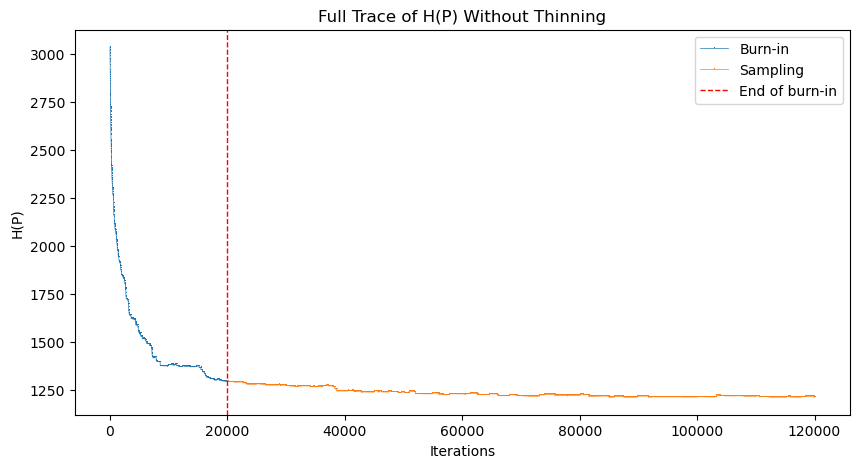

Integrated Autocorrelation Time (tau_int): 198.55
Recommended thinning every 199 iterations.


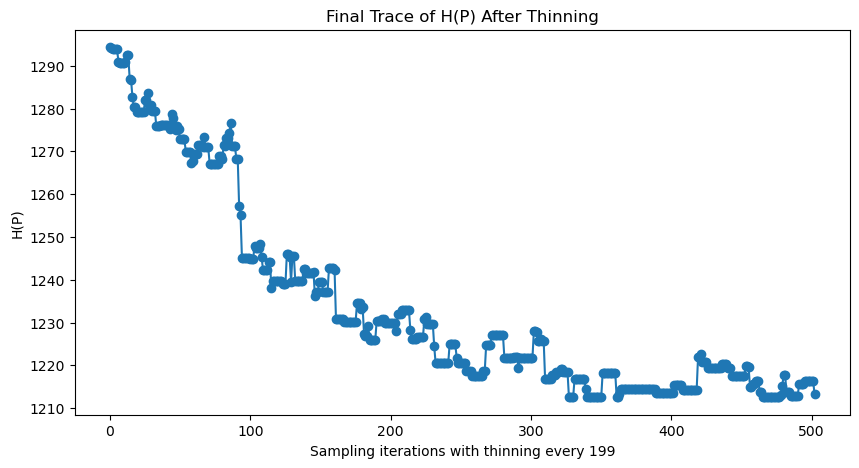

In [77]:
# Perform MCMC sampling on the observed network partitions, collecting the trace of H(P)
partitions, H_burn_in, H_full_trace = mcmc_trace_H(G_obs, equilibration=20000, num_samples=100000)

# Plot the H(P) trace
plot_H_trace(H_burn_in, H_full_trace)

# Compute the integrated autocorrelation time
tau_int, acfs = estimate_autocorrelation_time(H_full_trace, max_lag=100, threshold=0.05)
print(f"Integrated Autocorrelation Time (tau_int): {tau_int:.2f}")

# Choose thinning based on tau_int
thinning_interval = math.ceil(tau_int)
print(f"Recommended thinning every {thinning_interval} iterations.")



# Apply thinning to H(P) samples
H_final = H_full_trace[::thinning_interval]
# Apply thinning to partitions to obtain independent samples
partitions_thinned = partitions[::thinning_interval]

# Call the function to plot the final trace of H(P)
plot_final_H_trace(H_final, thinning_interval)

C:\Users\eugen\AppData\Local\Temp\ipykernel_25108\3441655393.py:22: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)


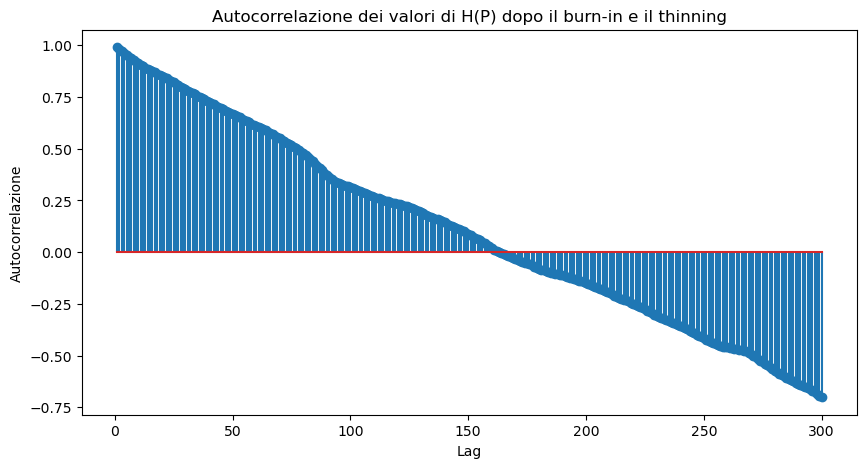

In [78]:
##### Poi questo lo togliamo, è solo per vedere come va l'autocorrelazione - RIFARE

def autocorrelation(series, max_lag):
    """ Calcola l'autocorrelazione per una serie di valori fino a max_lag. """
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    autocorrs = []

    for lag in range(1, max_lag + 1):
        ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
        autocorrs.append(ct / c0)

    return autocorrs

# Calcoliamo l'autocorrelazione per i valori di H(P) del burn-in
max_lag = 300  # Puoi variare questo valore per vedere fino a dove l'autocorrelazione decade
autocorr_values = autocorrelation(H_final, max_lag)

# Plottiamo la funzione di autocorrelazione
plt.figure(figsize=(10, 5))
plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.title("Autocorrelazione dei valori di H(P) dopo il burn-in e il thinning")
plt.show()


## 2 Compute the reliabilities

### 2.1 Link Reliability

This section introduces the function *estimate_link_reliability*, which calculates the link reliability $RL_{ij}$ for each node pair $(i,j)$ in a network, following a probabilistic formulation.

- The function iterates over a set of sampled partitions and computes the probability of a link existing between nodes, based on observed and expected connections.

- It uses the entropy function $H(P)$ to weigh partitions, ensuring statistically significant estimates.

- The result provides a normalized reliability score, which helps infer missing or uncertain links in noisy network data.

This method is useful for network reconstruction, link prediction, and structural analysis under uncertainty.

In [79]:
def estimate_link_reliability(G, partitions, H_values):
    """
    Estimates link reliability RL_ij for each pair (i, j) where i < j,
    using the formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Initialize dictionary for RL for all pairs (i, j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            reliability[(i, j)] = 0.0

     # Find the maximum H(P) value to compute c
    c = max(H_values)
    
    Z = 0.0  # Normalization factor
    
    for P, H_P in zip(partitions, H_values):
        weight = np.exp(-H_P + c)  # Adjusted weight with normalization constant c
        Z += weight
        
        # Group nodes by block for partition P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Precompute r and lO for each pair of blocks in partition P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # For identical blocks
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Count observed links within the block
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # For different block pairs
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Apply formula for each node pair (i, j) based on groups in P
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # If no observed links exist, lO defaults to 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # Avoid division by zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalize results
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

In [80]:
# Estimate link reliability for each node pair in the observed network
RL = estimate_link_reliability(G_obs, partitions, H_final)

# Print some results (e.g., for the first 10 pairs)
print("Link Reliability for selected node pairs:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Pair {key}: RL = {RL[key]:.4f}")


Link Reliability for selected node pairs:
Pair (0, 1): RL = 0.0357
Pair (0, 2): RL = 0.0357
Pair (0, 3): RL = 0.0982
Pair (0, 4): RL = 0.0357
Pair (0, 5): RL = 0.0571
Pair (0, 6): RL = 0.0244
Pair (0, 7): RL = 0.0357
Pair (0, 8): RL = 0.0571
Pair (0, 9): RL = 0.0244
Pair (0, 10): RL = 0.0351
Pair (0, 11): RL = 0.0982
Pair (0, 12): RL = 0.0119
Pair (0, 13): RL = 0.0119
Pair (0, 14): RL = 0.0119
Pair (0, 15): RL = 0.0175
Pair (0, 16): RL = 0.0297
Pair (0, 17): RL = 0.0175
Pair (0, 18): RL = 0.0248
Pair (0, 19): RL = 0.0769
Pair (0, 20): RL = 0.0351
Pair (0, 21): RL = 0.0297
Pair (0, 22): RL = 0.0982
Pair (0, 23): RL = 0.0982
Pair (0, 24): RL = 0.0351
Pair (0, 25): RL = 0.0297
Pair (0, 26): RL = 0.0982
Pair (0, 27): RL = 0.0526
Pair (0, 28): RL = 0.0351
Pair (0, 29): RL = 0.0351
Pair (0, 30): RL = 0.0351
Pair (0, 31): RL = 0.0351
Pair (0, 32): RL = 0.0224
Pair (0, 33): RL = 0.0297
Pair (0, 34): RL = 0.0297
Pair (0, 35): RL = 0.0526
Pair (0, 36): RL = 0.0526
Pair (0, 37): RL = 0.0224
Pair 

#### 2.1.1 Ranking Probability for Missing and Spurious Interactions in Networks

In [81]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false negative (AO=0, AT=1) has a higher RL
    than a true negative (AO=0, AT=0).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Build lists of node pairs based on definitions
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # If there are no examples, return None or 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # For each pair, add 1 if the false negative has a higher RL than the true negative,
    # 0.5 if they are equal.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability


def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false positive (AO=1, AT=0) has a lower RL
    than a true positive (AO=1, AT=1).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Here we want the false positive to have a lower RL than the true positive,
    # meaning in descending order the true positive should come first.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability




In [82]:
# Compute the probability for missing interactions (false negatives)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probability that a false negative has a higher RL than a true negative: {p_missing:.4f}")
else:
    print("Not enough examples for missing interactions.")
    
# Compute the probability for spurious interactions (false positives)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probability that a false positive has a lower RL than a true positive: {p_spurious:.4f}")
else:
    print("Not enough examples for spurious interactions.")

Probability that a false negative has a higher RL than a true negative: 0.9309
Probability that a false positive has a lower RL than a true positive: 0.9337


Missing interactions:
La probabilità che un false negative (un link che esiste nella rete vera ma manca nella rete osservata) abbia una reliability RL maggiore di un true negative (un link che non esiste né nella vera né nell’osservata).

Spurious interactions:
La probabilità che un false positive (un link spurio, cioè presente solo nella rete osservata) abbia una RL minore di un true positive (un link vero, cioè presente sia nella vera che nell’osservata).

Cosa significa un valore vicino a 1?
Se la probabilità è vicina a 1 (come 0.92 o 0.94), significa che:
Quasi sempre il tuo metodo assegna una reliability più alta ai link che dovrebbero esserci (missing) rispetto a quelli che non dovrebbero esserci (true negative).
Quasi sempre assegna una reliability più bassa ai link spurii rispetto ai veri positivi.
In altre parole:
Il tuo metodo è molto bravo a distinguere tra link veri e link falsi!
Se la probabilità fosse 0.5, significherebbe che il metodo non distingue (è come tirare a caso).
Se fosse < 0.5, significherebbe che il metodo sbaglia sistematicamente.

Perché è desiderabile?
Valori alti sono desiderabili: vuoi che i link veri siano sempre più affidabili (RL alta) dei link falsi.
Il tuo metodo funziona bene: i link che mancano per errore vengono comunque riconosciuti come "probabili" e i link spurii vengono riconosciuti come "improbabili".

#### 2.1.2 Accuracy of Missing and Spurious Interactions in Network Reconstruction

1. La cella va bene?
La cella sembra corretta nel calcolo delle accuratezze per le interazioni mancanti e spurie. Tuttavia, ci sono alcuni aspetti che potrebbero essere migliorati per evitare problemi di stabilità numerica e ottimizzare i calcoli.

2. Ci sono loop?
Sì, ci sono diversi loop annidati:

Loop sui nodi e sugli archi: Durante il calcolo di rank_probability_missing_interactions e rank_probability_spurious_interactions, vengono iterati tutti i nodi e gli archi per classificare le interazioni.
Loop sui campioni MCMC: Durante il calcolo di RL_missing e RL_spurious, vengono iterati tutti i campioni delle partizioni e i valori di entropia.
Questi loop possono diventare costosi per reti grandi o per un numero elevato di campioni MCMC. Se il calcolo è lento, potresti considerare l'ottimizzazione tramite vectorization o l'uso di librerie come NumPy.

3. Problemi nel calcolo dell'esponenziale di H
Il problema dell'esponenziale di H può verificarsi se i valori di H(P) sono molto grandi, causando un overflow numerico. Questo problema è mitigato nel tuo codice con l'uso di una costante di normalizzazione c:

Tuttavia, se H(P) varia molto tra i campioni, potresti comunque avere problemi di stabilità numerica. Per risolvere definitivamente:

Assicurati che c = max(H_values) sia calcolato correttamente.
Se i problemi persistono, considera di lavorare direttamente con i logaritmi per evitare il calcolo esplicito dell'esponenziale.
4. Quale traccia di H usare per RL_missing e RL_spurious?
Dipende da quale parte della catena vuoi utilizzare:

Se usi tutta la catena dopo il burn-in (senza thinning): Usa H_full_trace_missing e H_full_trace_spurious.
Se applichi il thinning per ridurre la correlazione tra i campioni: Usa H_final_missing e H_final_spurious, che sono versioni ridotte di H_full_trace dopo il thinning.
Esempio per il thinning:

Consiglio: Usa sempre la versione "thinned" (H_final_*) per garantire che i campioni siano indipendenti e ridurre il costo computazionale.

5. Suggerimenti per migliorare il codice
Ottimizzazione dei loop: Se possibile, usa librerie come NumPy per calcoli vettorializzati.
Stabilità numerica: Lavora con i logaritmi per evitare problemi di overflow.
Thinning: Usa sempre i campioni "thinned" per calcoli più efficienti e robusti.

In [83]:
def calculate_accuracies(G_true, error_fractions, num_samples=1000, equilibration=1000):
    accuracy_missing = []
    accuracy_spurious = []

    for f in error_fractions:
        # --- MISSING ---
        G_obs_missing = G_true.copy()
        edges = list(G_true.edges())
        num_remove = int(len(edges) * f)
        if num_remove > 0:
            remove_indices = np.random.choice(len(edges), num_remove, replace=False)
            for idx in remove_indices:
                G_obs_missing.remove_edge(*edges[idx])
        # MCMC + thinning
        parts, _, H_trace = mcmc_trace_H(G_obs_missing, equilibration, num_samples)
        thinning = max(1, int(estimate_autocorrelation_time(H_trace)[0]))
        H_final = H_trace[::thinning]
        parts_final = parts[::thinning]
        RL = estimate_link_reliability(G_obs_missing, parts_final, H_final)
        p_missing = rank_probability_missing_interactions(G_true, G_obs_missing, RL)
        accuracy_missing.append(1.0 if p_missing is None else p_missing)

        # --- SPURIOUS ---
        G_obs_spurious = G_true.copy()
        non_edges = list(nx.non_edges(G_true))
        num_add = int(len(edges) * f)
        if num_add > 0:
            add_indices = np.random.choice(len(non_edges), num_add, replace=False)
            for idx in add_indices:
                G_obs_spurious.add_edge(*non_edges[idx])
        # MCMC + thinning
        parts, _, H_trace = mcmc_trace_H(G_obs_spurious, equilibration, num_samples)
        thinning = max(1, int(estimate_autocorrelation_time(H_trace)[0]))
        H_final = H_trace[::thinning]
        parts_final = parts[::thinning]
        RL = estimate_link_reliability(G_obs_spurious, parts_final, H_final)
        p_spurious = rank_probability_spurious_interactions(G_true, G_obs_spurious, RL)
        accuracy_spurious.append(1.0 if p_spurious is None else p_spurious)

    return accuracy_missing, accuracy_spurious




In [84]:
error_fractions = np.linspace(0.05, 0.9, 10)
accuracy_missing, accuracy_spurious = calculate_accuracies(G_true, error_fractions, num_samples=15000, equilibration=100000)
plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious)

KeyboardInterrupt: 

### 2.2 Network reliability   -  <span style="color: RED;"> DA QUI IN POI SISTEMARE</span>

#### suggerimento copilot
Numerical Stability:

Ensure that the combinatorial term ( \ln\binom{r_{\alpha\beta}}{lO_{\alpha\beta}} ) does not cause overflow for large values of ( r_{\alpha\beta} ). Consider using logarithmic approximations for factorials if necessary.

Efficiency:

The nested loops in calculate_H and estimate_link_reliability may become computationally expensive for large networks. Optimizing these calculations (e.g., vectorization) could improve performance.

Validation:

Test the implementation on small, well-understood networks (e.g., toy examples) to verify that the calculated ( H(P) ) and link reliabilities match expected values.